In [27]:
import os
import glob
import itertools

import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import imgaug as ia
from PIL import Image
from imgaug import augmenters as iaa
from imgaug.augmentables import Keypoint, KeypointsOnImage

def hsv_to_rgb(h, s, v):
    if s == 0.0: return (v, v, v)
    i = int(h*6.) # XXX assume int() truncates!
    f = (h*6.)-i; p,q,t = v*(1.-s), v*(1.-s*f), v*(1.-s*(1.-f)); i%=6
    if i == 0: return (v, t, p)
    if i == 1: return (q, v, p)
    if i == 2: return (p, v, t)
    if i == 3: return (p, q, v)
    if i == 4: return (t, p, v)
    if i == 5: return (v, p, q)

In [83]:
transform = iaa.Sequential([
    # iaa.RandAugment(n=2, m=9),
    # iaa.ShearX((-20, 20)),
    # iaa.PiecewiseAffine(scale=(0.01, 0.05)),
    # iaa.WithPolarWarping(
    #     iaa.Affine(
    #         translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}
    #     )
    # ),
    # iaa.WithPolarWarping(iaa.AveragePooling((2, 8))),
    iaa.Jigsaw(nb_rows=8, nb_cols=8, max_steps=(3, 3)),
])

In [77]:
imsize = 256
sample_rate = 16
n = imsize // sample_rate
image = ia.quokka(size=(imsize, imsize))

kps = KeypointsOnImage([
    Keypoint(x=i * sample_rate, y=j * sample_rate)
    for i, j in itertools.product(range(n), range(n))
], shape=image.shape)

colors = [
    tuple(int(v * 255) for v in hsv_to_rgb(i / n**2, 1, 1))
    for i in range(n**2)
]

In [84]:
img_aug, kp_aug = transform(image=image, keypoints=kps)

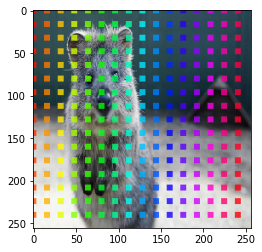

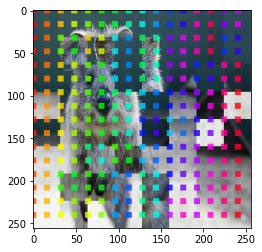

In [85]:
image_before = image
for kp, c in zip(kps, colors):
    image_before = kp.draw_on_image(image_before, size=7, color=c, alpha=.8)

image_after = img_aug
for kp, c in zip(kp_aug, colors):
    image_after = kp.draw_on_image(image_after, size=7, color=c, alpha=.8)

# image_before = kps.draw_on_image(image)
# image_after = kp_aug.draw_on_image(img_aug)

plt.imshow(image_before)
plt.show()
plt.imshow(image_after)
plt.show()

In [ ]:
#123234